### Data Preprocessing and Vanilla Logistic Regression with L2-Regularizer (or elastic net?)

In [16]:
% matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, confusion_matrix

from sklearn.linear_model import LogisticRegressionCV

from matplotlib import pyplot as plt

In [17]:
# Complete feature list
features = ["Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Marital Status",
            "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
            "Hours per week", "Country", "Target"]

# Read data
train_data = pd.read_csv('../data/adult_train.csv',
                         names = features,
                         sep = r'\s*,\s*',
                         engine = 'python',
                         na_values = "?")
test_data = pd.read_csv('../data/adult_test.csv',
                        names = features,
                        sep = r'\s*,\s*',
                        engine = 'python',
                        na_values = "?")

# Drop irrelevant columns
# "fnlwgt" is a control feature related to how data was sampled
# "Education" is the discrete version of "Education-Num"

train_data = train_data.drop(["fnlwgt", "Education"], axis = 1)
test_data  = test_data.drop(["fnlwgt", "Education"], axis = 1)

# Check for missing values in target column
check_target_nan_train = train_data['Target']
check_target_nan_test  = test_data['Target']
print('Number of missing entries in target column, train data:', len(check_target_nan_train) - check_target_nan_train.count())
print('Number of missing entries in target column, test data:', len(check_target_nan_test) - check_target_nan_test.count())

Number of missing entries in target column, train data: 0
Number of missing entries in target column, test data: 0


/Users/austin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/austin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/austin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/austin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to 

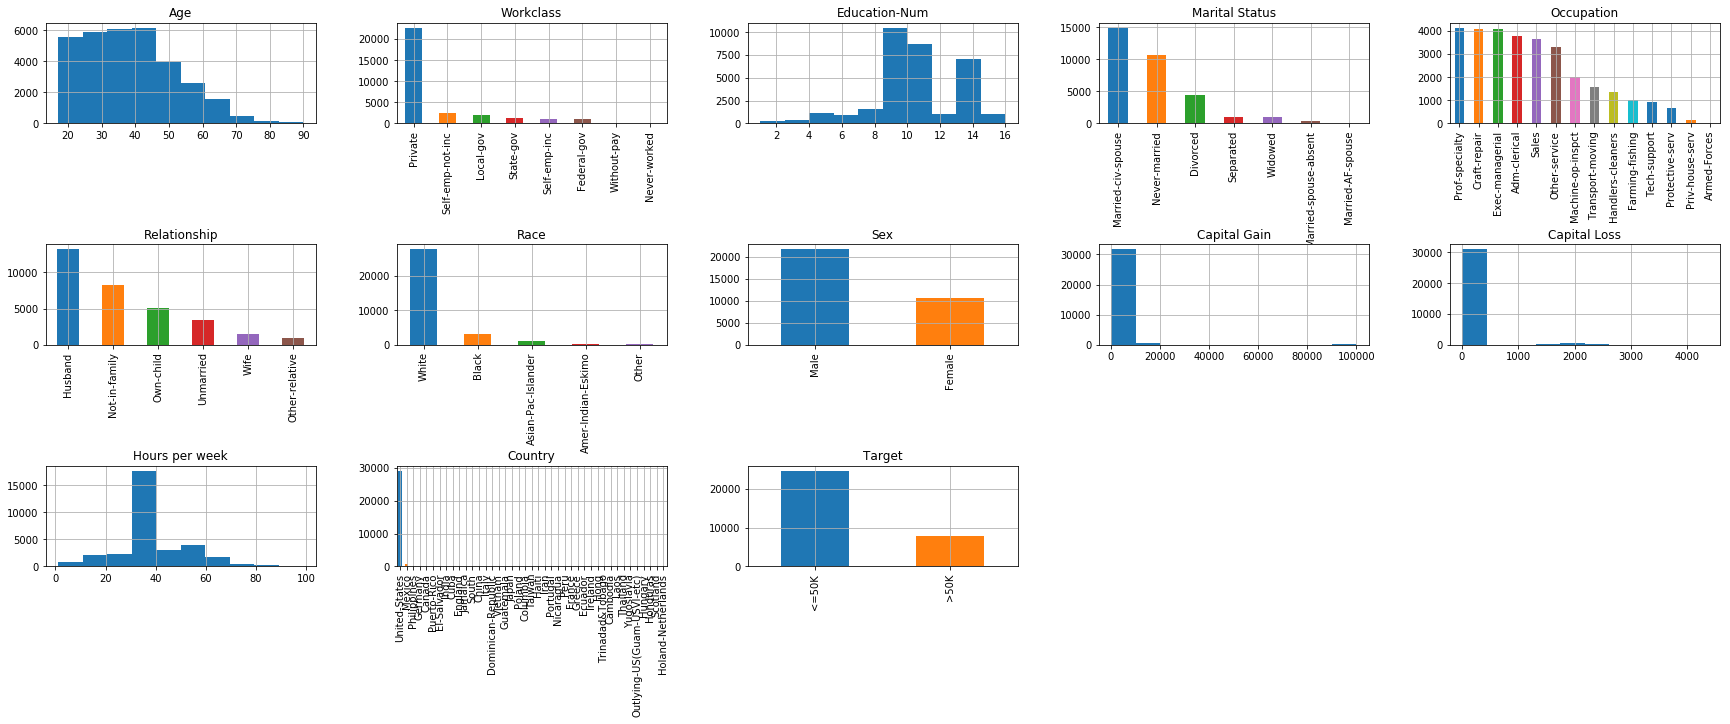

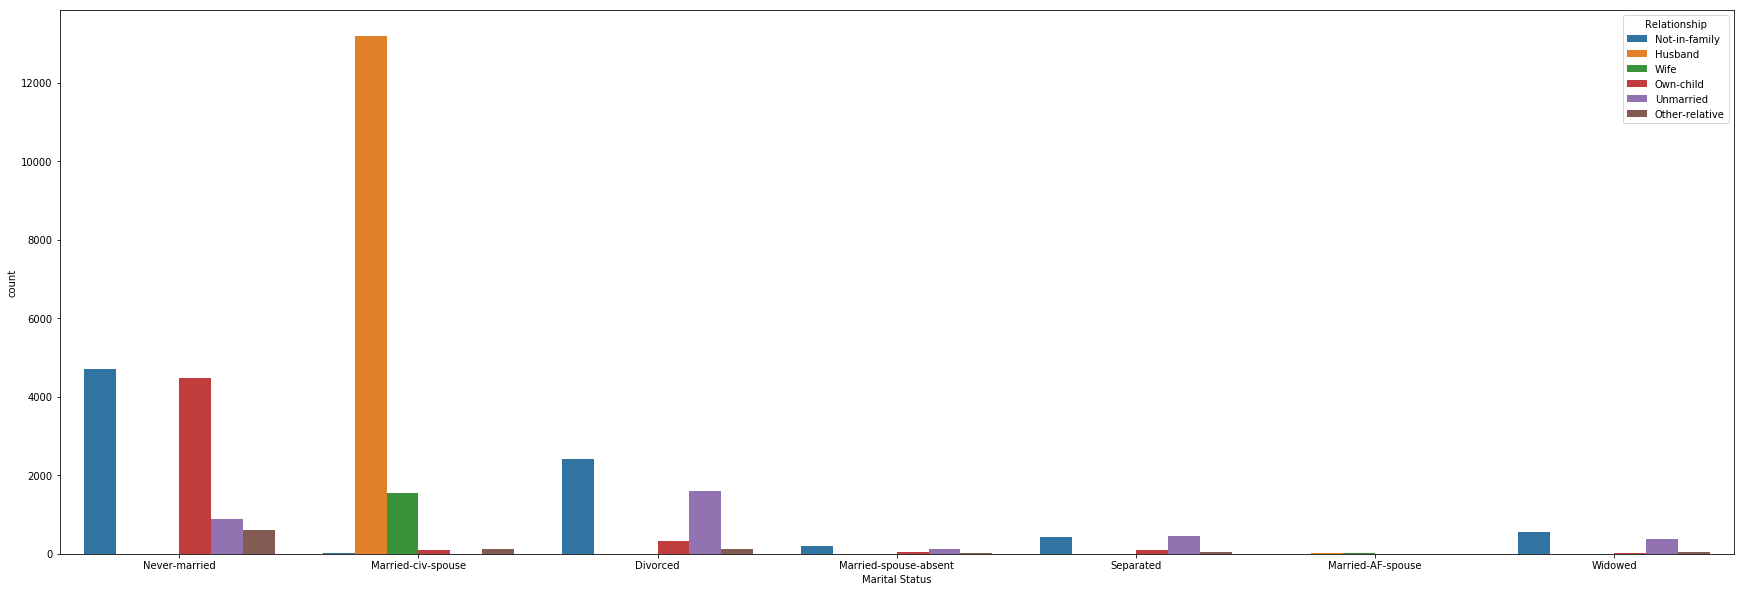

In [18]:
# Plot 1-D histograms for all features
fig = plt.figure(figsize = (30, 10))
numRows = 3;
numCols = 5;

for i, col in enumerate(train_data.columns):
    ax = fig.add_subplot(numRows, numCols, i+1)
    ax.set_title(col)
    if train_data.dtypes[col] == np.object:
        train_data[col].value_counts().plot(kind = 'bar', axes = ax)
        plt.grid()
    else:
        train_data[col].hist(axes = ax)
        
plt.subplots_adjust(hspace = 1.2, wspace = 0.3)

# Comments:
# 1. We can compress countries as US / non-US
# 2. We can compress race as White / non-White or White / Black / Other
# 3. We can compress workclass as Private / non-Private
# 3. 'Marital Status' and 'Relationship' appear to have significant overlap
# 4. We can guess that 'Occupation' and 'Education' have a big impact on the target
# We will use them to pre-determine a gender/race/other bias in the data

# Compress country as US / non-US (except for NaN)
train_data['Country'][train_data['Country'].str.contains('United-States') == False] = 'Non-US'
test_data['Country'][test_data['Country'].str.contains('United-States') == False] = 'Non-US'

# Compress workclass as Private / non-Private
train_data['Workclass'][train_data['Workclass'].str.contains('Private') == False] = 'Non-Private'
test_data['Workclass'][test_data['Workclass'].str.contains('Private') == False] = 'Non-Private'

# Plot cross-histograms of 'Marital Status' and 'Relationship' to ballpark correlation
plt.figure(figsize = (30, 10))
sns.countplot(x = "Marital Status", hue = 'Relationship', data = train_data)

# Since 'Relationship' also has some correlation with gender, we decide to drop it
train_data = train_data.drop(["Relationship"], axis = 1)
test_data  = test_data.drop(["Relationship"], axis = 1)

# Encode categorical features using dummy random variables
encoded_train_data = pd.get_dummies(train_data,
                                    columns = ["Workclass", "Race", "Marital Status",
                                               "Occupation", "Sex",
                                               "Country", "Target"],
                                    prefix = ["workclass", "race", "marital_status",
                                              "occupation", "sex",
                                              "country", "target"])
encoded_test_data = pd.get_dummies(test_data,
                                   columns = ["Workclass", "Race", "Marital Status",
                                              "Occupation", "Sex",
                                              "Country", "Target"],
                                   prefix = ["workclass", "race", "marital_status",
                                             "occupation", "sex",
                                             "country", "target"])

# Remove the dummy feature with most frequent value for colinearity reasons
# This also takes care of the '?' by implictly replacing them with the most common entry
encoded_train_data = encoded_train_data.drop(["workclass_Private", "race_White",
                                             "marital_status_Married-civ-spouse", "occupation_Prof-specialty",
                                             "sex_Male", "country_United-States", "target_<=50K"],
                                             axis = 1)
encoded_test_data = encoded_test_data.drop(["workclass_Private", "race_White",
                                             "marital_status_Married-civ-spouse", "occupation_Prof-specialty",
                                             "sex_Male", "country_United-States", "target_<=50K"],
                                             axis = 1)

#print(encoded_train_data.columns.values.tolist())
#print(encoded_test_data.columns.values.tolist())

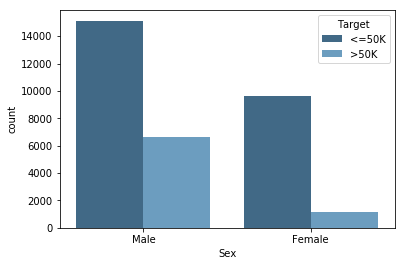

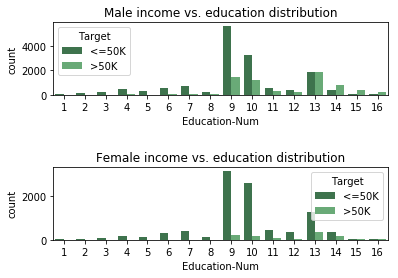

In [19]:
# Anticipating gender/race bias in the data
# Overall bias
fig = plt.figure()
sns.countplot(x = "Sex", hue = "Target", data = train_data, palette = "Blues_d")

# Gender-education bias w.r.t. income
male_data = train_data[train_data["Sex"] == 'Male']
female_data = train_data[train_data["Sex"] == 'Female']

fig = plt.figure()
# Male plot
fig.add_subplot(2, 1, 1)
sns.countplot(x = "Education-Num", hue = "Target", data = male_data, palette="Greens_d")
plt.title("Male income vs. education distribution")
# Female plot
fig.add_subplot(2, 1, 2)
sns.countplot(x = "Education-Num", hue = "Target", data = female_data, palette="Greens_d")
plt.title("Female income vs. education distribution")

plt.subplots_adjust(hspace = 1)

Best auc_roc: 0.9093600880886334
Confusion matrix, without normalization
[[11584  1611]
 [  851  2235]]
Best auc_roc: 0.9093508003929728
Regression coefficients: [[ 0.32127637  0.78692506  2.3396073   0.26448452  0.39455512 -0.06466721
  -0.60329904 -0.06300694 -0.13784983 -0.59743893 -2.12754646  0.6904874
  -2.17473753 -2.65593402 -2.24078854 -2.17563847 -0.16857775 -0.61874965
  -0.23111734  0.49699773 -1.54494083 -0.93570995 -0.52699288 -1.07336452
  -4.43116175  0.22935857 -0.03053018  0.38323431 -0.38466635 -0.14968303
  -0.18144245]]


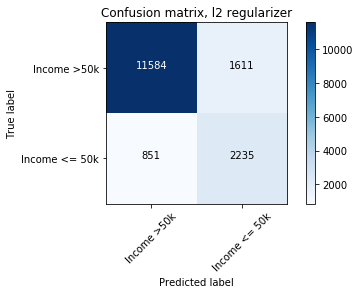

In [20]:
# Centering and normalizing continuous columns entries
numerical_features = ["Age", "Education-Num", "Capital Gain", "Capital Loss", "Hours per week"]

for featureName in numerical_features:
    encoded_train_data[featureName] = (encoded_train_data[featureName] - np.mean(encoded_train_data[featureName], axis=0)) / np.std(encoded_train_data[featureName], axis=0)
    encoded_test_data[featureName]  = (encoded_test_data[featureName] - np.mean(encoded_test_data[featureName], axis=0)) / np.std(encoded_test_data[featureName], axis=0)
    
X_train = encoded_train_data.drop(["target_>50K"], axis = 1);
y_train = encoded_train_data["target_>50K"];
X_test  = encoded_test_data.drop(["target_>50K"], axis = 1);
y_test  = encoded_test_data["target_>50K"];

# Confusion matrix plot sub-routine
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Run vanilla logistic regression, L2 regularization
logreg = LogisticRegressionCV(Cs = list(np.power(10.0, np.arange(-10, 10))),
                              penalty = 'l2',
                              scoring = 'roc_auc',
                              refit = True, # Refit with best C
                              cv = 10,
                              random_state = 777,
                              solver = 'liblinear')
logreg.fit(X_train, y_train)

# Report best C parameter found - TODO!
print('Best auc_roc:', logreg.scores_[1].max())

# Evaluate test set performance
y_pred = logreg.predict(X_test)

# Confusion matrix
C = confusion_matrix(y_pred, y_test)
plot_confusion_matrix(C,
                      classes=["Income >50k", "Income <= 50k"],
                      title='Confusion matrix, l2 regularizer')


# Run vanilla logistic regression, Lasso regularization
logregL1 = LogisticRegressionCV(Cs = list(np.power(10.0, np.arange(-10, 10))),
                                penalty = 'l1',
                                scoring = 'roc_auc',
                                refit = True, # Refit with best C
                                cv = 10,
                                random_state = 777,
                                solver = 'liblinear')
logregL1.fit(X_train, y_train)

# Report found coefficients
print('Best auc_roc:', logregL1.scores_[1].max())
print('Regression coefficients:', logregL1.coef_)

# TODO: Need to Lasso a bit more aggressively
# Currently at 31 features

In [45]:
import h5py

X_h5 = pd.concat([X_train, X_test]).as_matrix()
y_h5 = pd.concat([y_train, y_test]).as_matrix()
labels_h5 = [str.encode(xi) for xi in X_train.columns]

try:
    f = h5py.File('../data/data_31.h5', 'w')
except(OSError):
    f.close()
    f = h5py.File('../data/data_31.h5', 'w')
    
f.create_dataset('data', data=X_h5)
f.create_dataset('target', data=y_h5)
f.create_dataset('labels', data=labels_h5)
f.close()

In [35]:
X_train.columns[29]

str

In [33]:
f.close()